In [1]:
import pandas as pd
import numpy as np
import shap
import torch
import scipy.stats

/home/ruben/Documents/virtualenv/vub_sdms/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
BASE_FOLDER = './outputs/evaluation'

In [30]:
def load_data(prefix, traffic):
    df_single_episode = pd.read_csv(f'{BASE_FOLDER}/{prefix}_1_episode_{traffic}.csv')
    df_single_episode = df_single_episode.set_index('step')
    df_single_episode = df_single_episode.drop(columns=['cumulative_reward'])
    
    df_multiple_episodes = pd.read_csv(f'{BASE_FOLDER}/{prefix}_100_episode_{traffic}.csv')
    df_multiple_episodes = df_multiple_episodes.set_index('episode')
    # df_multiple_episodes = df_multiple_episodes.drop(columns=['cumulative_reward'])
    return df_single_episode, df_multiple_episodes

def extract_obs_data(df):
    # Convert obs and probabilities to separate dataset
    obs = []
    prob = df.termination_prob.to_list()
    options = df.option.to_list()
    for step, item in enumerate(df.obs.tolist()):
        item = [float(s.strip()) for s in item.split(',')]
        data = {
            'option': options[step],
            'prob': prob[step],
            'min_green': item[4]
        }
        for i in range(0, 4):
            data[f'green_light_{i}'] = item[i]
        for i in range(8):
            item_index = i + 5
            data[f'lane_{i}_density'] = item[item_index]
            item_index2 = i + 13
            data[f'lane_{i}_queue'] = item[item_index2]
        obs.append(data)        
    df_probs_obs = pd.DataFrame(obs)
    return df_probs_obs

In [5]:
df_single_episode, _ = load_data('oc_2way_500k_steps', 'custom-2way-single-intersection')

In [31]:
df_probs_obs = extract_obs_data(df_single_episode)

In [ ]:
# Visualisations

In [36]:
def extract_avg(df):
    data = []
    for _, row in df.iterrows():
        row = row.to_dict()
        density = []
        queue = []
        record = {
            'option': row['option']
        }
        for key in row:
            if 'density' in key:
                density.append(row[key])
            elif 'queue' in key:
                queue.append(row[key])
        record['avg_density'] = np.mean(density)
        record['avg_queue'] = np.mean(queue)
        data.append(record)
    return pd.DataFrame(data)

In [38]:
df_avgs = extract_avg(df_probs_obs)

<Axes: xlabel='avg_density', ylabel='avg_queue'>

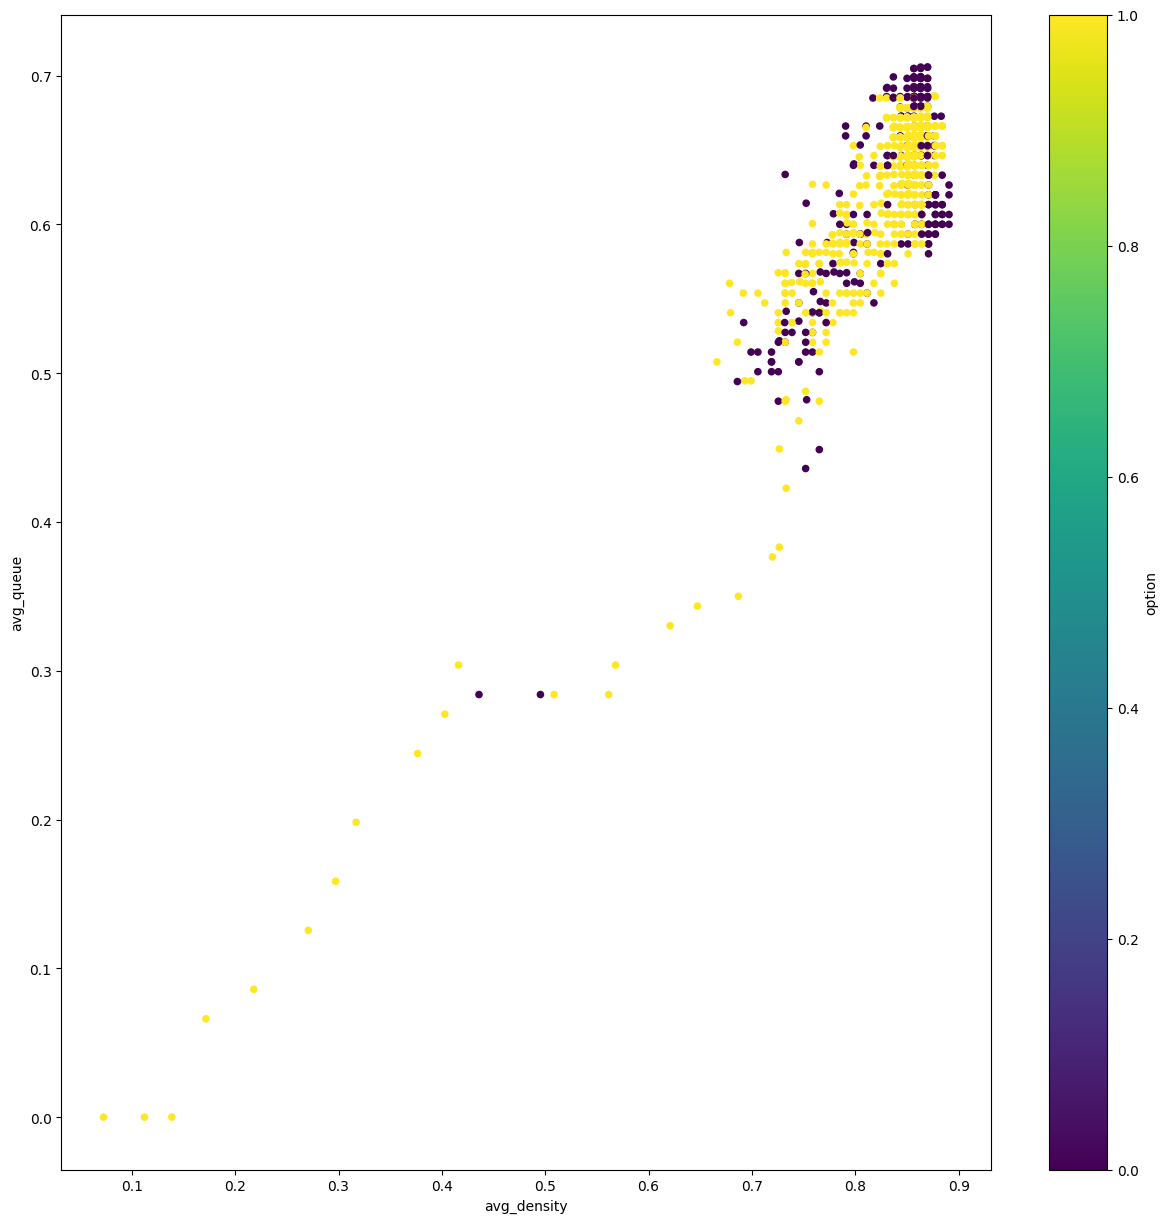

In [42]:
df_avgs.plot.scatter(x='avg_density', y='avg_queue', c='option', figsize=(15,15))

In [14]:
# Correlations

In [17]:
def calculate_correlation_df(df):
    results = []
    columns = df.columns
    for column in columns:
        if column != 'prob':
            correlation = df['prob'].corr(df[column])
            results.append({
                'test': f'Correlation between prob and {column}',
                'correlation': correlation
            })
    pd_correlation = pd.DataFrame(results)
    return pd_correlation

In [13]:
df_probs_obs.cov()['prob'].sort_values(ascending=False)

lane_7_queue      0.024922
lane_3_queue      0.024869
lane_7_density    0.013484
lane_3_density    0.013423
prob              0.010526
lane_2_queue      0.006303
lane_6_queue      0.006066
lane_6_density    0.001366
lane_2_density    0.001365
min_green        -0.001552
lane_4_density   -0.001759
lane_0_density   -0.001793
lane_4_queue     -0.007879
lane_0_queue     -0.007937
lane_5_density   -0.008470
lane_1_density   -0.009444
lane_5_queue     -0.016513
lane_1_queue     -0.018537
option           -0.018787
Name: prob, dtype: float64

In [20]:
df_correlation = calculate_correlation_df(df_probs_obs)
df_correlation.sort_values('correlation', ascending=False)

,test,correlation
8,Correlation between prob and lane_3_density,0.721588
16,Correlation between prob and lane_7_density,0.716227
17,Correlation between prob and lane_7_queue,0.697896
9,Correlation between prob and lane_3_queue,0.697418
7,Correlation between prob and lane_2_queue,0.227150
15,Correlation between prob and lane_6_queue,0.219503
6,Correlation between prob and lane_2_density,0.115354
14,Correlation between prob and lane_6_density,0.112487
1,Correlation between prob and min_green,-0.033704
10,Correlation between prob and lane_4_density,-0.099118


In [ ]:
# Shap
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(64, 2)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
model_params = torch.load(
            "./models/option_critic_2_options_custom-single-intersection.csv_4000000_steps"
        )['model_params']
termination_state_dict = {
    'linear_relu_stack.0.weight': model_params['terminations.weight'],
    'linear_relu_stack.0.bias': model_params['terminations.bias']
}
model = NeuralNetwork()
model.load_state_dict(termination_state_dict)

In [ ]:
explainer = shap.explainers.Linear(model, X_std)
shap_values = explainer(X_std)
shap.plots.waterfall(shap_values[sample_ind], max_display=14)

In [ ]:
lanes = ['n_t_0', 'n_t_1', 'e_t_0', 'e_t_1', 's_t_0', 's_t_1', 'w_t_0', 'w_t_1']
          0          1         2       3         4         5     6        7